## Skin Deep Learning Training Notebook

In [31]:

import keras as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import tensorflow as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split


In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading and Preprocessing data

In [62]:
#Reading the metadata_csv to see what the current DataFrame looks like.

metadata_path = 'gdrive/My Drive/Google Colab Data/Skin/HAM10000_metadata.csv'
#metadata_path = 'C:/Users/edmon/Documents/Datasets/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [63]:
#Creating New Columns for better readability

newpath = 'gdrive/My Drive/Google Colab Data/Skin/HAM10000_images_part_1/'
#newpath = 'C:/Users/edmon/Documents/Datasets/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'
metadata['path'] = metadata['image_id'].map(lambda x: newpath+x+".jpg")
print(list(metadata['path'])[6])

#Writes cell_type & cell_type_index features to the csv

metadata['cell_type'] = metadata['dx'].map(lesion_type_dict.get) 
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes
#metadata.head(5)

C:/Users/edmon/Documents/Datasets/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0029176.jpg


In [12]:
#Resizing images to a 100x75x3 matrix and storing them as a new feature 
#for the DF

metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image\
.open(x).resize((100,75))))
# metadata.head(5)

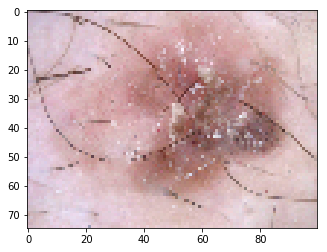

In [14]:
#Plotting one image to confirm that the previous step was successful
plt.figure()
plt.imshow(metadata['image'][10010])

### Cleaning and Preparing Data for Training

In [15]:
#Setting X & y values, in this case image is X and cell_type_idx is y
X = metadata['image'].values
y = metadata['cell_type_idx'].values

In [16]:
"""nx, ny represent the image resolution of the training dataset.
When we use this model for prediction later, 
These values will be used to resize any images uploaded""" 
nx = X[1].shape[1]
ny = X[1].shape[0]

#nc by convention; Referencing the number of channels used.
nc = X[1].shape[2]
m = X.shape[0]

#reshape X to a nicer shape and print dimentions
X = np.concatenate(X).reshape(m,ny,nx,nc)
X.shape

(10015, 75, 100, 3)

In [17]:
np.save('y75x100.npy', [X, y, m, ny, nx, nc])

### Exploratory Data Analysis

Text(0, 0.5, 'Count')

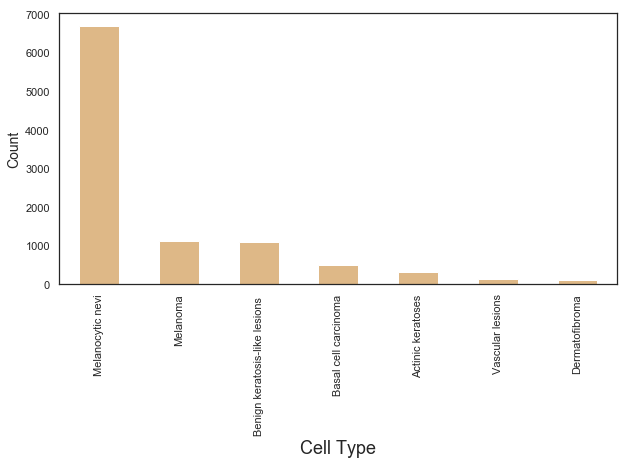

In [88]:
fig, ax1 = plt.subplots(1, 1, figsize = (10,5))
metadata['cell_type'].value_counts().plot(kind='bar', ax=ax1, color = 'burlywood')
plt.xlabel('Cell Type', fontsize = 18)
plt.ylabel('Count', fontsize = 14)

Text(0, 0.5, 'Count')

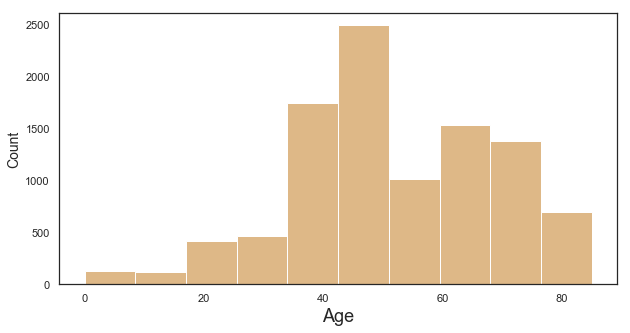

In [87]:
fig2, ax2 = plt.subplots(1, sharey = True, figsize = (10,5))
plt.hist(metadata['age'], color='burlywood')
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=14)


In [64]:
#Get one hot encoding of cell_type column
one_hot = pd.get_dummies(metadata['cell_type'])
one_hot.head()
#Join encoded dataframe
metadata = metadata.join(one_hot)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,Actinic keratoses,Basal cell carcinoma,Benign keratosis-like lesions,Dermatofibroma,Melanocytic nevi,Melanoma,Vascular lesions
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/edmon/Documents/Datasets/skin-cancer-...,Benign keratosis-like lesions,0,0,1,0,0,0,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/edmon/Documents/Datasets/skin-cancer-...,Benign keratosis-like lesions,0,0,1,0,0,0,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/edmon/Documents/Datasets/skin-cancer-...,Benign keratosis-like lesions,0,0,1,0,0,0,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/edmon/Documents/Datasets/skin-cancer-...,Benign keratosis-like lesions,0,0,1,0,0,0,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/edmon/Documents/Datasets/skin-cancer-...,Benign keratosis-like lesions,0,0,1,0,0,0,0


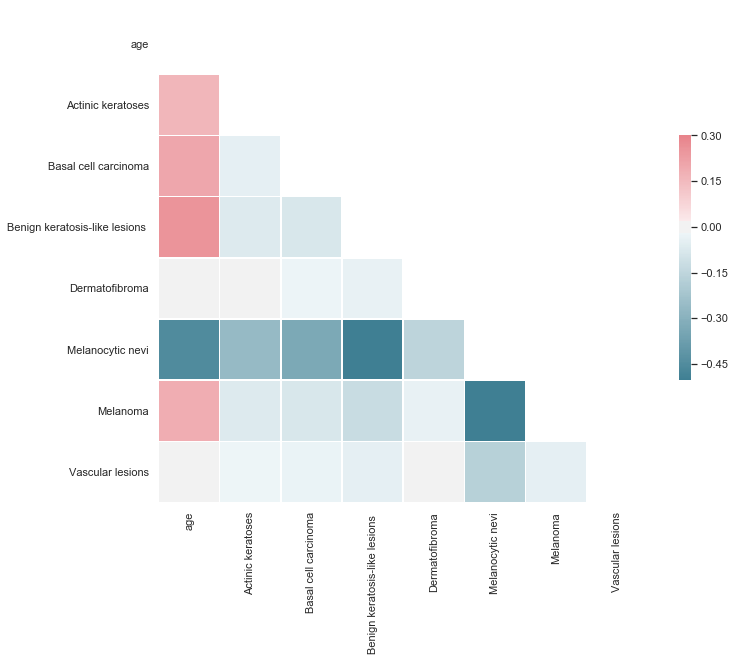

In [65]:
#Dropping index column to prevent correlation calculation when non-applicable
metadata = metadata.drop(['cell_type_idx'], axis=1)
#Setting seaborn style
sns.set(style = 'white')
#Computing correlation matrix
corr = metadata.corr()
#Generating mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Setting up plt figure
f, ax = plt.subplots(figsize = (11,9))

#Generating custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap = True)

#Drawing heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True,
           linewidths=.5, cbar_kws={'shrink': .5})